In [108]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import datetime
pd.set_option('display.max_columns',100)
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [109]:
# set seed
np.random.seed(7)

In [110]:
# path = 'G:/.shortcut-targets-by-id/1BMwGDvpAqVWZD7P9pYvgrhsUE0PSUQlV/TC_Research/Cell_Data/2020/2020-01'
# cname = ["datetime", "route", "km", "direction", "all_units", "inflow_units", "outflow_unit", "samecell_units", "speed",
#          "max_speed", "avg_traveltime", "max_traveltime"]

In [111]:
# # append dataframes for one month cell data
# dfs = []
# for file in glob.glob(path+'/data_2020-01-*.csv'):
#     df = pd.read_csv(file,names=cname,engine='python')
#     df_ = df[(df['route']== 7) & (df['km'] == 1) & (df['direction'] == 'in')]
#     dfs.append(df_)

In [112]:
# # concat dataframe
# df = pd.concat(dfs)

In [121]:
# laod data
df = pd.read_csv('route7km1.csv')

In [122]:
# look at datahead
df.head()

,Unnamed: 0,datetime,route,km,direction,all_units,inflow_units,outflow_unit,samecell_units,speed,max_speed,avg_traveltime,max_traveltime
0,1566,2020-01-01 00:00:44,7,1,in,1,1,0,0,116,116,30,30
1,12793,2020-01-01 00:03:37,7,1,in,5,3,0,2,83,149,50,61
2,16627,2020-01-01 00:04:35,7,1,in,2,2,0,0,74,82,59,75
3,20708,2020-01-01 00:05:33,7,1,in,2,2,0,0,93,99,49,61
4,24757,2020-01-01 00:06:31,7,1,in,2,2,0,0,76,83,46,59


In [123]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [124]:
# sort data by datetime
df = df.sort_values(by=['datetime'])

In [125]:
# we want to predict the speed in the next 10 minutes
df1 = df.groupby(pd.Grouper(key="datetime", freq="10min")).mean()

In [126]:
# df1 head
df1.head()

,Unnamed: 0,route,km,all_units,inflow_units,outflow_unit,samecell_units,speed,max_speed,avg_traveltime,max_traveltime
datetime,,,,,,,,,,,
2020-01-01 00:00:00,21807.250000,7.0,1.0,2.750000,2.375000,0.0,0.375000,87.125000,101.875000,45.000000,58.125000
2020-01-01 00:10:00,59587.333333,7.0,1.0,2.000000,2.000000,0.0,0.000000,91.222222,104.333333,43.111111,50.000000
2020-01-01 00:20:00,99295.300000,7.0,1.0,2.900000,2.800000,0.0,0.100000,90.700000,103.900000,40.100000,46.400000
2020-01-01 00:30:00,141877.111111,7.0,1.0,2.666667,2.555556,0.0,0.111111,81.444444,95.000000,39.555556,49.111111
2020-01-01 00:40:00,177889.000000,7.0,1.0,2.777778,2.444444,0.0,0.333333,88.000000,107.222222,35.666667,41.888889


In [127]:
dataset = df1['speed'].to_frame().values
dataset = dataset.astype('float32')


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# normalize dataset by MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
speed = df['speed'].values.astype("float32").reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(df.speed.values)

In [11]:
# Split dataset into 60% training and 40% testing
# train_ratio = 0.6
# train_size = int(len(dataset) * train_ratio)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (26235, 17491)


In [132]:
# normalize dataset by MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
speed = scaler.fit_transform(df1.speed.values.reshape(-1,1))

In [138]:
df2 = pd.DataFrame(speed,columns=['speed'])
df2.head()

,speed
0,0.868631
1,0.912126
2,0.906582
3,0.808327
4,0.877919


In [139]:
train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
print(len(train), len(test))

3571 893


In [141]:
train.head()

,speed
0,0.868631
1,0.912126
2,0.906582
3,0.808327
4,0.877919


In [142]:
train = pd.DataFrame(train.speed)
test = pd.DataFrame(test.speed)

In [143]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [144]:
time_steps = 10
# reshape to samples, time_steps, n_features
X_train, y_train = create_dataset(train, train.speed, time_steps)
X_test, y_test = create_dataset(test, test.speed, time_steps)
print(X_train.shape, y_train.shape)

(3561, 10, 1) (3561,)


In [152]:
model = Sequential()
model.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer=optimizers.Adam(0.001))

In [153]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
201/201 [==============================] - 5s 24ms/step - loss: 0.0209 - val_loss: 0.0058
Epoch 2/30
201/201 [==============================] - 4s 17ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 3/30
201/201 [==============================] - 3s 17ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 4/30
201/201 [==============================] - 4s 17ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 5/30
201/201 [==============================] - 4s 18ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 6/30
201/201 [==============================] - 4s 18ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 7/30
201/201 [==============================] - 3s 17ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 8/30
201/201 [==============================] - 4s 18ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 9/30
201/201 [==============================] - 3s 17ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 10/30
201/201 [==============================] - 3s 17ms/step - loss: 0.0052 - val_lo

In [154]:
# predict X_test
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'test')

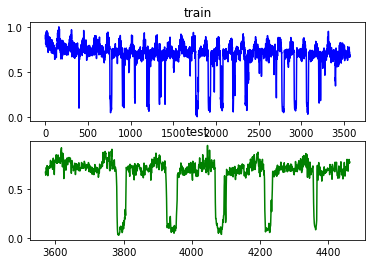

In [168]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df2.speed.iloc[:train_size],'-b')
ax[0].set_title('train')
ax[1].plot(df2.speed.iloc[train_size:],'-g')
ax[1].set_title('test')

Text(0.5, 1.0, 'predict on the test set')

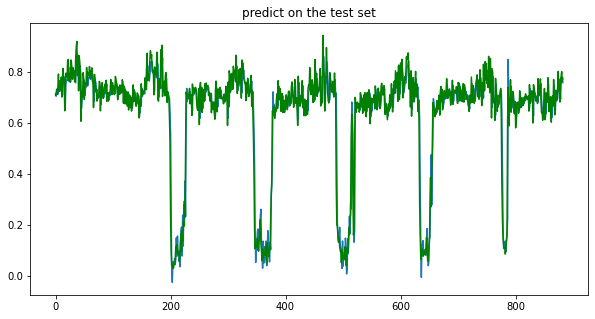

In [169]:
# plot the prediction
plt.figure(figsize=(10,5))
plt.plot(y_pred)
plt.plot(y_test,'-g')
plt.title('predict on the test set')